In [16]:
import sinter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from collections import defaultdict
from typing import Optional, List
import math

#from get_circuits_for_timelike_distance

# Functions used to process the data

In [23]:
def extrapolate_footprint_achieving_error_rate(
        group: List[sinter.TaskStats],
        target_p: float,
) -> Optional[sinter.Fit]:
    """Taken from Craig Gidney's code.
    
    Args:
        group: A list of TaskStats objects.
        target_p: The target probability of failure, for teraquop use 1e-12.

    Returns:
        A Fit object representing the footprint that would achieve the target
        probability of failure, or None if the data was insufficient.
    """
    assert len({stat.json_metadata['per'] for stat in group}) == 1
    sqrt_qs = []
    log_ps = []
    for stat in group:
        if stat.shots:
            p_shot = stat.errors / stat.shots
            if 0 < p_shot < 0.5:

                p_unit = p_shot
                sqrt_qs.append(math.sqrt(stat.json_metadata['distance']**2))
                log_ps.append(math.log(p_unit))
#            else:
 #               print(p_shot)
  #              print(stat.errors, "errors")
   #             print(stat)
    if len(log_ps) < 3:
        print(sqrt_qs)
        print(stat)
    if len(log_ps) < 2:
        # Can't interpolate a slope from 1 data point.
#        raise ValueError("Not enough data to extrapolate footprint.")
        print('error, only 1 point')
        return None

    slope_fit = sinter.fit_line_slope(
        xs=log_ps,
        ys=sqrt_qs,
        max_extra_squared_error=1,
    )
    if slope_fit.best >= 0:
        # Slope is going the wrong way! Definitely over threshold.
        print('error, slope is going the wrong way')
        return None

    fit = sinter.fit_line_y_at_x(
        xs=log_ps,
        ys=sqrt_qs,
        target_x=math.log(target_p),
        max_extra_squared_error=1,
    )

    return sinter.Fit(
        low=fit.low**2,
        best=fit.best**2,
        high=fit.high**2,
    )

# Functions used to generate plots

In [18]:

def float_to_color_shade(value: int, color_map: plt.cm, vmin=200, vmax=3000):
    """
    Convert a float between 1 and 1000 to a shade of blue.

    Parameters
    ----------
    value : float
        The float value to convert.
    vmin : float
        The minimum value of the range. Default is 1.
    vmax : float
        The maximum value of the range. Default is 1000.

    Returns
    -------
    color : tuple
        The RGBA color corresponding to the input value.
    """
    # Normalize the value to the range [0, 1]
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    normalized_value = norm(value)

    # Get the color corresponding to the normalized value
    color = color_map(normalized_value)

    return color

# Data processing

### Import and filter data

In [19]:
stats : List[sinter.TaskStats] = sinter.stats_from_csv_files('./out/d_d_d_memory_experiment_0.001.csv')

stats_00001_memory_x = [stat for stat in stats if stat.json_metadata['per'] == 0.001 and stat.json_metadata['logical_observable'] == 'memory_x']
stats_00001_memory_z = [stat for stat in stats if stat.json_metadata['per'] == 0.001 and stat.json_metadata['logical_observable'] == 'memory_z']
print(stats_00001_memory_z)


[sinter.TaskStats(strong_id='ccc07e117b0c91fa8096a62b0057165b3129a7232b6bf415e6405b85286e4cc4', decoder='pymatching', json_metadata={'code_name': 'GaugeFloquetColourCode', 'distance': 12, 'gf_0': 1, 'gf_1': 1, 'gf_2': 0, 'logical_observable': 'memory_z', 'per': 0.001, 'pm': 1.0, 'px': 1.0, 'py': 1.0, 'pz': 1.0}, shots=1000000, errors=37, seconds=36.692), sinter.TaskStats(strong_id='56876674fd749052bc91f138dd4f8fb93773aed20fc85179799f17538f2559f6', decoder='pymatching', json_metadata={'code_name': 'GaugeFloquetColourCode', 'distance': 12, 'gf_0': 2, 'gf_1': 2, 'gf_2': 0, 'logical_observable': 'memory_z', 'per': 0.001, 'pm': 1.0, 'px': 1.0, 'py': 1.0, 'pz': 1.0}, shots=824004, errors=110, seconds=40.634), sinter.TaskStats(strong_id='548fd9948c6da5f015eaa107d22fd79b11fa209da9d88524faa82022ed216140', decoder='pymatching', json_metadata={'code_name': 'GaugeFloquetColourCode', 'distance': 12, 'gf_0': 1, 'gf_1': 2, 'gf_2': 0, 'logical_observable': 'memory_z', 'per': 0.001, 'pm': 1.0, 'px': 1.

### Calculate Teraquop footprints

In [24]:
def calc_teraquop_footprints(stats):
    noise_model_groups = sinter.group_by(stats, key = lambda stat: str(stat.json_metadata['px'])+ ',' + str(stat.json_metadata['py']) + ',' + str(stat.json_metadata['pz']) + ',' + str(stat.json_metadata['pm']))
    noise_model_footprints = defaultdict()

    for noise_model_key, noise_model_group in noise_model_groups.items():

        code_name_groups = sinter.group_by(noise_model_group, key = lambda stat: (stat.json_metadata['code_name'], stat.json_metadata['gf_0'], stat.json_metadata['gf_1'], stat.json_metadata['gf_2']))
        noise_model_footprints[noise_model_key] = defaultdict()
        for code_name_key, code_name_group in code_name_groups.items(): 
            noise_model_footprints[noise_model_key][code_name_key] = extrapolate_footprint_achieving_error_rate(
                    code_name_group,
                    target_p=10**(-12))
    return(noise_model_footprints)

x_footprints = calc_teraquop_footprints(stats_00001_memory_x)
#z_footprints = calc_teraquop_footprints(stats_00001_memory_z)

[4.0, 8.0]
   1000000,        12,         0,    18.7,pymatching,5a1ca10757dbc5708f8720d84c4f7365b41a5d42889d31d8053a97df0dddc7e6,"{""code_name"":""GaugeFloquetColourCode"",""distance"":8,""gf_0"":3,""gf_1"":1,""gf_2"":0,""logical_observable"":""memory_x"",""per"":0.001,""pm"":16.0,""px"":1.0,""py"":1.0,""pz"":1.0}",


### Find best footprints

In [21]:
def get_best_footprint(footprints: dict):
    lowest_footprint = None
    lowest_footprint_name = None
    lowest_footprint_gauge_honeycomb_code = None
    lowest_footprint_floquet_color_code = None
    for code_name, footprint in footprints.items():
        if footprint is not None and (lowest_footprint is None or footprint.best < lowest_footprint):
            lowest_footprint = footprint.best
            lowest_footprint_name = code_name
        if code_name[0] == 'GaugeHoneycombCode':
            if footprint is not None and (lowest_footprint_gauge_honeycomb_code is None or footprint.best < lowest_footprint_gauge_honeycomb_code):
                lowest_footprint_gauge_honeycomb_code = footprint.best
        if code_name[0] == 'GaugeFloquetColourCode':
            if footprint is not None and (lowest_footprint_floquet_color_code is None or footprint.best < lowest_footprint_floquet_color_code):
                lowest_footprint_floquet_color_code = footprint.best
    return lowest_footprint_name, lowest_footprint, lowest_footprint_gauge_honeycomb_code, lowest_footprint_floquet_color_code

def get_best_footprint_dict(footprints: dict):
    best_footprints = dict()
    best_footprints_honeycomb_code_value = dict()
    best_footprints_floquet_color_code_value = dict()
    for noise_model, footprints in footprints.items():
        best_footprints[noise_model], _, best_footprints_honeycomb_code_value[noise_model], best_footprints_floquet_color_code_value[noise_model] = get_best_footprint(footprints)
    print(best_footprints)
    return best_footprints, best_footprints_honeycomb_code_value, best_footprints_floquet_color_code_value

best_footprints_x, best_footprints_honeycomb_code_value_x, best_footprints_floquet_color_code_value_x = get_best_footprint_dict(x_footprints)
best_footprints_z, best_footprints_honeycomb_code_value_z, best_footprints_floquet_color_code_value_z = get_best_footprint_dict(z_footprints)

{'1.0,1.0,1.0,1.0': ('GaugeFloquetColourCode', 2, 1, 0), '1.0,1.0,1.0,16.0': ('GaugeFloquetColourCode', 3, 1, 0), '1.0,1.0,1.0,4.0': ('GaugeFloquetColourCode', 2, 1, 0), '1.0,1.0,1.0,8.0': ('GaugeFloquetColourCode', 3, 1, 0), '1.0,1.0,16.0,1.0': ('GaugeHoneycombCode', 2, 1, 1), '1.0,1.0,16.0,16.0': ('GaugeHoneycombCode', 2, 2, 2), '1.0,1.0,16.0,4.0': ('GaugeHoneycombCode', 3, 1, 1), '1.0,1.0,16.0,8.0': ('GaugeHoneycombCode', 2, 1, 1), '1.0,1.0,4.0,1.0': ('GaugeHoneycombCode', 1, 1, 1), '1.0,1.0,4.0,16.0': ('GaugeFloquetColourCode', 3, 1, 0), '1.0,1.0,4.0,4.0': ('GaugeFloquetColourCode', 2, 1, 0), '1.0,1.0,4.0,8.0': ('GaugeFloquetColourCode', 2, 1, 0), '1.0,1.0,8.0,1.0': ('GaugeHoneycombCode', 1, 1, 1), '1.0,1.0,8.0,16.0': ('GaugeFloquetColourCode', 2, 1, 0), '1.0,1.0,8.0,4.0': ('GaugeHoneycombCode', 2, 1, 1), '1.0,1.0,8.0,8.0': ('GaugeFloquetColourCode', 2, 1, 0)}
{'1.0,1.0,1.0,1.0': ('GaugeHoneycombCode', 1, 1, 1), '1.0,1.0,1.0,16.0': ('GaugeFloquetColourCode', 2, 3, 0), '1.0,1.0,1.0,

# Generate plots

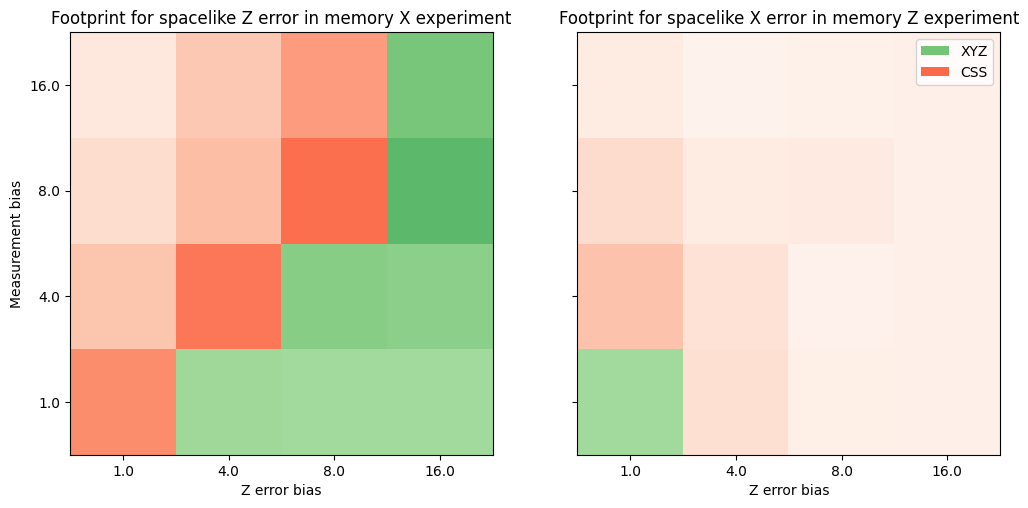

In [37]:
def plot_best_footprints(best_footprints: dict, best_footprints_honeycomb_code_value: dict, best_footprints_floquet_color_code_value: dict, ax: plt.Axes):

    x_y_to_color = dict()
    x_values = list()
    y_values = list()
    for noise_model, best_footprint in best_footprints.items():
        x_val = float(noise_model.split(',')[-2])
        y_val = float(noise_model.split(',')[-1])
        if best_footprint[0] == 'GaugeHoneycombCode':
            x_y_to_color[(x_val, y_val)] = float_to_color_shade(best_footprints_honeycomb_code_value[noise_model], plt.cm.Greens)
        elif best_footprint[0] == 'GaugeFloquetColourCode':
            x_y_to_color[(x_val, y_val)] = float_to_color_shade(best_footprints_floquet_color_code_value[noise_model], plt.cm.Reds)    

        if x_val not in x_values:
            x_values.append(x_val)
        if y_val not in y_values:
            y_values.append(y_val)


    x_values.sort()
    y_values.sort()



    color_matrix = [[0 for i in range(len(y_values))] for j in range(len(x_values))]
    for x_val in x_values:
        for y_val in y_values:
            if (x_val, y_val) in x_y_to_color:
                color_matrix[y_values.index(y_val)][x_values.index(x_val)] = x_y_to_color[(x_val, y_val)]

    ax.imshow(color_matrix, origin = 'lower')
    ax.set_xticks(np.arange(len(x_values)), labels=x_values)
    ax.set_yticks(np.arange(len(y_values)), labels=y_values)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax1.set_ylabel('Measurement bias')
ax1.set_xlabel('Z error bias')
ax2.set_xlabel('Z error bias')
ax1.set_title('Footprint for spacelike Z error in memory X experiment')
ax2.set_title('Footprint for spacelike X error in memory Z experiment')


plot_best_footprints(best_footprints_x, best_footprints_honeycomb_code_value_x, best_footprints_floquet_color_code_value_x, ax1)
plot_best_footprints(best_footprints_z, best_footprints_honeycomb_code_value_z, best_footprints_floquet_color_code_value_z, ax2)
from  matplotlib.patches import Patch
# TODO add some kind of legend 
legend_elements = [
    Patch(facecolor=plt.cm.Greens(0.5), label='XYZ'),##edgecolor='r', label='GaugeHoneycombCode'),
    Patch(facecolor=plt.cm.Reds(0.5), label='CSS')
]

#ax1.legend(handles=legend_elements, loc='upper right')
ax2.legend(handles=legend_elements, loc='upper right')

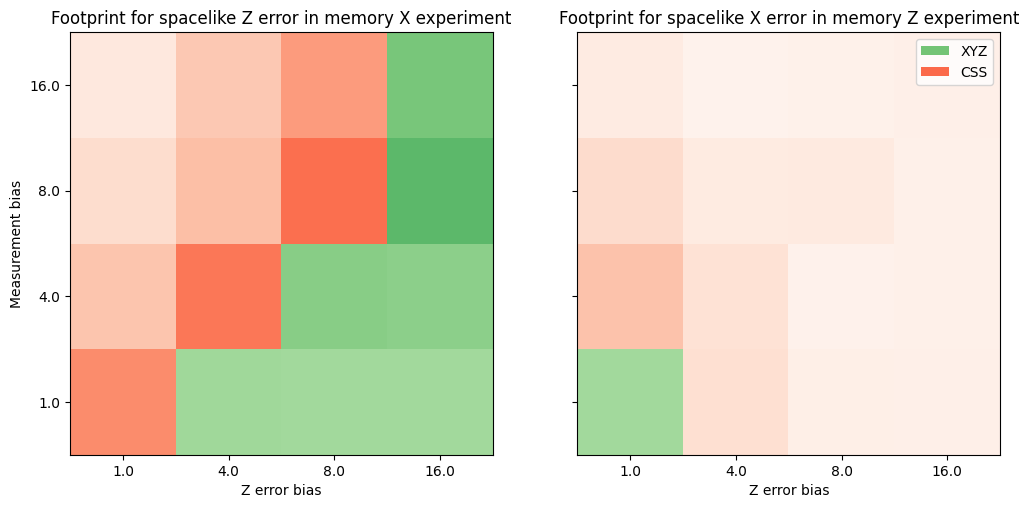

## Left plot

### Top left (high measurement bias, no Z-error bias)
- The optimal CSS code here has X-gauge factor 3 and Z-gauge factor 1. The minimum spacelike logical formed using measurement error has weight $3 \times d$
- The optimal XYZ code here has X,Y, and Z gauge factor 3. The minimum spacelike logical formed using measurement error has weight $3 \times d$
-  The optimal XYZ code takes twice as many rounds as  the optimal CSS code.

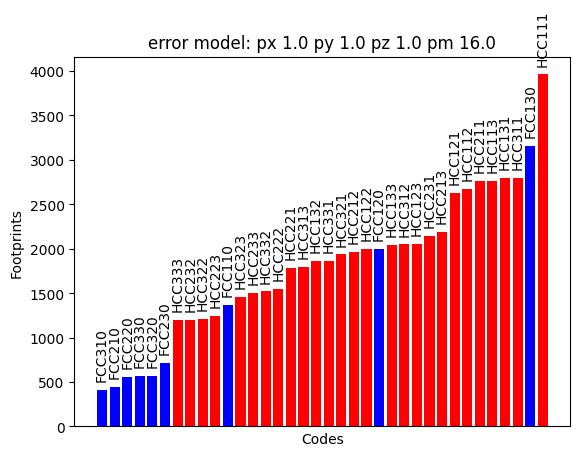

### Bottom right
- In the CSS code Pauli-Z and Y errors form logical spacelike errors in a memory X-experiment. 
- In the XYZ code Pauli-X,Y and Z errors form logical spacelike errors in a memory X-experiment.
- The CSS code is more negatively effected by Z biased noise.

### Top right
- The advantage that the XYZ code has for Z biased noise apparently outweights the advantage the CSS code has for measurement biased noise.

## Right plot
### Bottom right
- In the CSS code, Pauli X and Y errors form logical errors in a Z-memory experiment.
- In the XYZ code, Pauli X,Y and Z errors form logical errors in a X-memory experiment.
### Top left
- The optimal CSS code here has X-gauge factor 1 and Z-gauge factor 3. The minimum spacelike logical formed using measurement error has weight $3 \times d$
- The optimal XYZ code here has X,Y, and Z gauge factor 3. The minimum spacelike logical formed using measurement error has weight $3 \times d$
-  The optimal XYZ code takes twice as many rounds as  the optimal CSS code.

In [34]:
def format_code_label(code_name):
    code_name_to_label = {
        'FloquetColourCode': 'FCC',
        'HoneycombCode': 'HCC',
        'GaugeHoneycombCode': 'HCC',
        'GaugeFloquetColourCode': 'FCC'
    }
    label = code_name_to_label.get(code_name[0], code_name)
    formatted_values = ''.join(map(str, code_name[1:]))
    return f'{label}{formatted_values}'


def plot_footprints(footprints,error_model):
    sorted_items = sorted(footprints[error_model].items(), key=lambda item: item[1].best if item[1] is not None else float('inf'))
    code_name_to_color = {'GaugeFloquetColourCode': 'blue', 'GaugeHoneycombCode': 'red'}
    for code_name, footprint in sorted_items:
        
        

        if footprint is not None:
            formatted_label = format_code_label(code_name)

            bars = plt.bar(str(code_name), float(footprint.best), color=code_name_to_color.get(code_name[0], 'black'))
            for bar in bars:
                height = bar.get_height() + 100
                plt.text(bar.get_x() + bar.get_width() / 2.0, height, formatted_label, ha='center', va='bottom', rotation=90)

    # Add labels and title
    plt.xlabel('Codes')
    plt.ylabel('Footprints')
    error_rates = error_model.split(',')
    plt.title(f'error model: px {error_rates[0]} py {error_rates[1]} pz {error_rates[2]} pm {error_rates[3]}')
    plt.xticks([])
    plt.show()


NameError: name 'best_footprints_floquet_color_code_value' is not defined

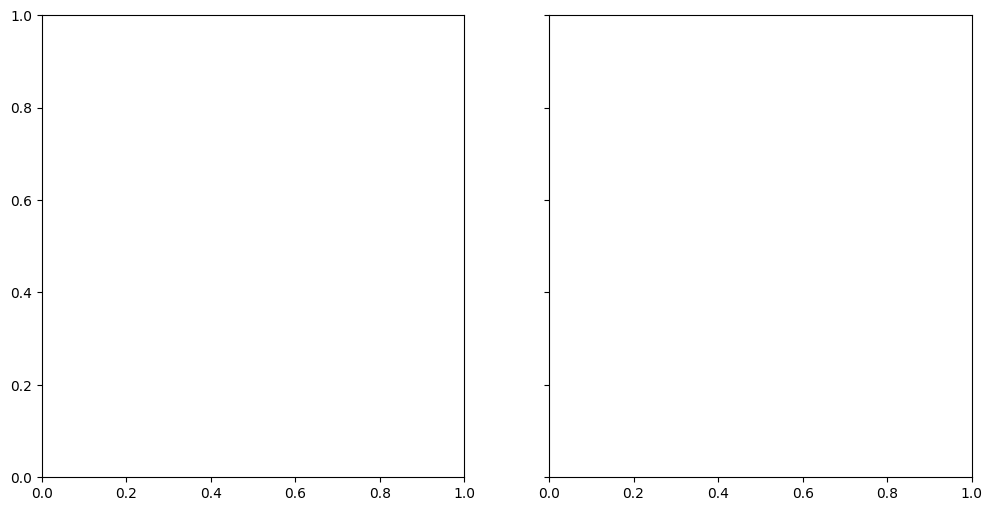

In [30]:


def generate_plot(best_footprints):
    x_y_to_color = defaultdict()
    x_values = list()
    y_values = list()
    for noise_model, best_footprint in best_footprints.items():
        x_y_to_color[(noise_model.split(',')[-2], noise_model.split(',')[-1])] = float_to_blue_shade(best_footprint)
        if noise_model.split(',')[-2] not in x_values:
            x_values.append(noise_model.split(',')[-2])
            
        if noise_model.split(',')[-1] not in y_values:
            y_values.append(noise_model.split(',')[-1])
    print(x_values)
    print(y_values)

    x_values.sort()
    y_values.sort()
    y_values = y_values[::-1]
    color_matrix = [[0 for i in range(len(y_values))] for j in range(len(x_values))]
    for x_val in x_values:
        for y_val in y_values:
            if (x_val, y_val) in x_y_to_color:
                color_matrix[x_values.index(x_val)][y_values.index(y_val)] = x_y_to_color[(x_val, y_val)]

    x_values = [float(x) for x in x_values]
    y_values = [float(y) for y in y_values]
    return color_matrix, x_values, y_values

# Create two subplots next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Generate the data for the first heatmap
color_matrix, x_values, y_values = generate_plot(best_footprints_floquet_color_code_value)



# Plot the first heatmap
im1 = ax1.imshow(color_matrix)
ax1.set_xticks(np.arange(len(x_values)))
ax1.set_xticklabels(x_values)
ax1.set_yticks(np.arange(len(y_values)))
ax1.set_yticklabels(y_values)
ax1.set_xlabel('Z bias')
ax1.set_ylabel('Measurement bias')
ax1.set_title('Floquet color code')

# Plot the second heatmap (you can modify this to plot different data)
#im2 = ax2.imshow(color_matrix_2)
color_matrix, x_values, y_values = generate_plot(best_footprints_honeycomb_code_value)
im2 = ax2.imshow(color_matrix)
ax2.set_xticks(np.arange(len(x_values)))
ax2.set_xticklabels(x_values)
ax2.set_yticks(np.arange(len(y_values)))
ax2.set_yticklabels(y_values)
ax2.set_xlabel('Z bias')
ax2.set_title('Honeycomb code')

plt.tight_layout()
plt.show()

In [31]:
code_name_to_color = {'GaugeFloq': 1,'GaugeHone': 10}

x_y_to_color = defaultdict()
x_values = list()
y_values = list()
for noise_model, best_footprint in best_footprints.items():
    code_name = (noise_model.split(',')[-2])
    print(best_footprint[0][:9])
    x_y_to_color[(noise_model.split(',')[-2], noise_model.split(',')[-1])] = code_name_to_color[best_footprint[0][:9]]
    if noise_model.split(',')[-2] not in x_values:
        x_values.append(noise_model.split(',')[-2])
    if noise_model.split(',')[-1] not in y_values:
        y_values.append(noise_model.split(',')[-1])

x_values.sort()
y_values.sort()
y_values = y_values[::-1]
color_matrix = [[0 for i in range(len(y_values))] for j in range(len(x_values))]
for x_val in x_values:
    for y_val in y_values:
        if (x_val, y_val) in x_y_to_color:
            color_matrix[x_values.index(x_val)][y_values.index(y_val)] = x_y_to_color[(x_val, y_val)]


x_values = [float(x) for x in x_values]
y_values = [float(y) for y in y_values]
print(x_values)
print(y_values)

plt.imshow(color_matrix)
plt.xticks(np.arange(len(x_values)), labels=x_values)
plt.yticks(np.arange(len(y_values)), labels=y_values)
plt.xlabel('Z bias')
plt.ylabel('Measurement bias')

NameError: name 'best_footprints' is not defined

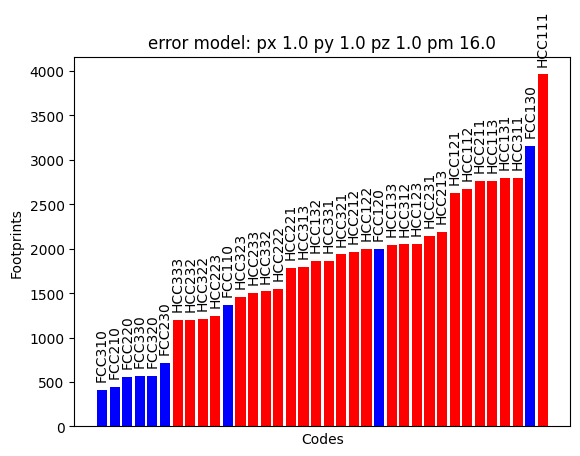

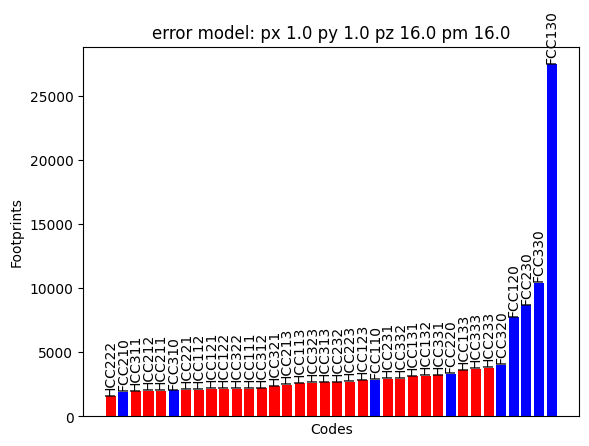

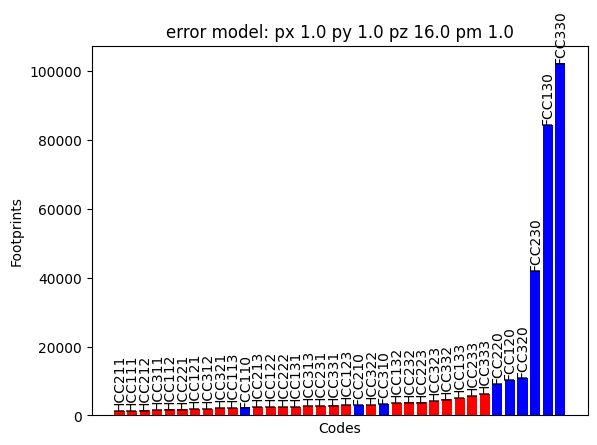

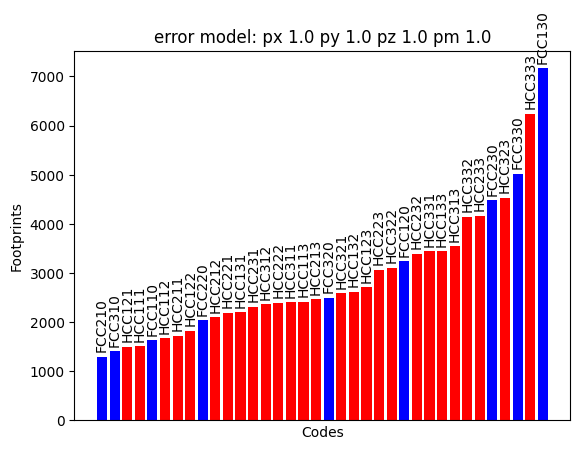

In [32]:
plot_footprints(x_footprints, '1.0,1.0,1.0,16.0')
plot_footprints(x_footprints, '1.0,1.0,16.0,16.0')
plot_footprints(x_footprints, '1.0,1.0,16.0,1.0')
plot_footprints(x_footprints, '1.0,1.0,1.0,1.0')


NameError: name 'color_matrix' is not defined

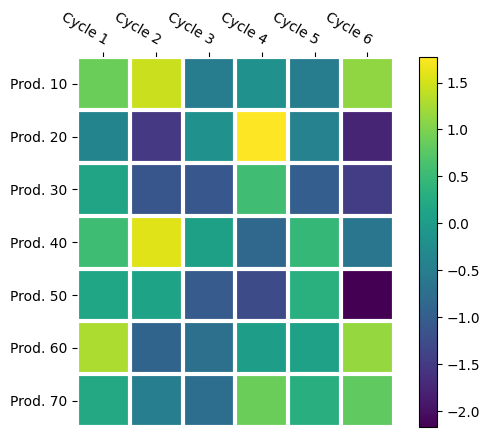

In [ ]:
import numpy as np
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

data = np.random.randn(7, 6)
y = [f"Prod. {i}" for i in range(10, 80, 10)]
x = [f"Cycle {i}" for i in range(1, 7)]
qrates = list("ABCDEFG")
norm = matplotlib.colors.BoundaryNorm(np.linspace(-3.5, 3.5, 8), 7)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: qrates[::-1][norm(x)])

im, _ = heatmap(data, y, x)



In [ ]:
imshow
print(data)
print(colors)
#im, _ = heatmap(colors, y_cords, x_cords)


[[-0.07151069  1.18280717 -0.95828172  0.5717842   0.53571285  0.63972755]
 [-0.35030957  0.83208399 -1.3920888  -0.25202288  1.32337813 -0.27991457]
 [-0.99903546 -1.1257055   0.29360627 -0.11919822 -0.2198939   0.92073018]
 [-0.08638644  0.93319565  0.75481009 -1.45229548  1.12567024  0.6403062 ]
 [ 1.2766022  -0.81366911 -0.84092399 -0.29938742 -0.94413404  0.79590808]
 [-0.64452359 -0.38958075 -0.12229497 -0.19471646  0.21670726  0.72245511]]
[1, 1, 1, 1, 1, 1, 1, 10, 10, 1, 10, 10, 1, 10, 10, 10]


In [ ]:
code_name_to_color = {'FloquetColourCode': 1,'HoneycombCode': 10}
x_y_to_color = defaultdict()
x_values = list(  )
y_values = list()
for noise_model, best_footprint in best_footprints.items():
    code_name = (noise_model.split(',')[-2])
    print(best_footprint)
    x_y_to_color[(noise_model.split(',')[-2], noise_model.split(',')[-1])] = code_name_to_color[best_footprint]
    if noise_model.split(',')[-2] not in x_values:
        x_values.append(noise_model.split(',')[-2])
    if noise_model.split(',')[-1] not in y_values:
        y_values.append(noise_model.split(',')[-1])

x_values.sort()
y_values.sort()
y_values = y_values[::-1]
color_matrix = [[0 for i in range(len(y_values))] for j in range(len(x_values))]
for x_val in x_values:
    for y_val in y_values:
        if (x_val, y_val) in x_y_to_color:
            color_matrix[x_values.index(x_val)][y_values.index(y_val)] = x_y_to_color[(x_val, y_val)]


x_values = [float(x) for x in x_values]
y_values = [float(y) for y in y_values]

# go from px,py,pz,pm to x and y coordinate


# go from code_name to color

In [ ]:
from typing import Literal
from main.codes.tic_tac_toe.gauge.GaugeFloquetColourCode import GaugeFloquetColourCode
from main.codes.tic_tac_toe.gauge.GaugeHoneycombCode import GaugeHoneycombCode
from main.building_blocks.detectors.Stabilizer import Stabilizer
from main.compiling.compilers.AncillaPerCheckCompiler import AncillaPerCheckCompiler
from main.compiling.noise.models import PhenomenologicalNoise
from main.compiling.syndrome_extraction.extractors.ancilla_per_check.mixed.CxCyCzExtractor import CxCyCzExtractor
from matplotlib import pyplot as plt
from typing import Literal
import stim

def get_hyper_edge_distance(circuit: stim.Circuit) -> int:

    logical_errors = circuit.search_for_undetectable_logical_errors(
        dont_explore_detection_event_sets_with_size_above=6,
        dont_explore_edges_with_degree_above=6,
        dont_explore_edges_increasing_symptom_degree=False,
    )

    return len(logical_errors)

def get_graphlike_distance(circuit: stim.Circuit) -> int:
    return len(circuit.detector_error_model(
        approximate_disjoint_errors=True, decompose_errors=True, ignore_decomposition_failures=True).shortest_graphlike_error())
def generate_circuit(code: Literal['HoneycombCode'],
                     rounds: int,
                     observable_type: str = 'X',
                     pauli_noise_probability: float = 0.1,
                     measurement_noise_probability: float = 0.1) -> stim.Circuit:
    """Generates a quantum error correction circuit for the Honeycomb code.

    Args:
        rounds (int): The number of rounds for the circuit.
        distance (int): The distance of the Honeycomb code.
        observable_type (str): The type of logical observable ('X' or 'Z'). Defaults to 'X'.

    Returns:
        Any: The compiled stim circuit.
    """

    if observable_type == 'X':
        logical_observables = [code.x_stability_operator]

        initial_stabilizers = [Stabilizer([(0, check)], 0)
                               for check in code.check_schedule[code.gauge_factors[0] + code.gauge_factors[1]]]
        final_measurements = code.get_possible_final_measurement(
            code.logical_qubits[1].z, rounds)

    elif observable_type == 'Z':
        logical_observables = [code.z_stability_operator]
        initial_stabilizers = [Stabilizer([(0, check)], 0)
                               for check in code.check_schedule[0]]
        final_measurements = code.get_possible_final_measurement(
            code.logical_qubits[0].x, rounds)

    noise_model = PhenomenologicalNoise(
        pauli_noise_probability, measurement_noise_probability)

    compiler = AncillaPerCheckCompiler(
        noise_model=noise_model,
        syndrome_extractor=CxCyCzExtractor()
    )
    stim_circuit = compiler.compile_to_stim(
        code=code,
        total_rounds=rounds,
        initial_stabilizers=initial_stabilizers,
        observables=logical_observables,
        final_measurements=final_measurements
    )

    return stim_circuit

fcc_ds = []
hcc_ds = []
for n_rounds in range(18, 25):

    code: GaugeFloquetColourCode = GaugeFloquetColourCode(4, [3,1])
    circ = generate_circuit(code, n_rounds, 'X', 0.1, 0.1)
    fcc_ds.append(get_hyper_edge_distance(circ))

    code: GaugeHoneycombCode = GaugeHoneycombCode(4, [3,3,3])
    circ =  generate_circuit(code, n_rounds, 'X', 0.1, 0.1)
    hcc_ds.append(get_hyper_edge_distance(circ))

print(fcc_ds)
print(hcc_ds)

|████████████████████████████████████████| 92/92 [100%] in 0.2s (555.55/s)      
|████████████████████████████████████████| 92/92 [100%] in 0.2s (529.69/s)      
|████████████████████████████████████████| 97/97 [100%] in 0.2s (548.23/s)      
|████████████████████████████████████████| 97/97 [100%] in 0.2s (550.04/s)      
|████████████████████████████████████████| 102/102 [100%] in 0.2s (543.88/s)    
|████████████████████████████████████████| 102/102 [100%] in 0.2s (543.37/s)    
|████████████████████████████████████████| 107/107 [100%] in 0.2s (580.52/s)    
|████████████████████████████████████████| 107/107 [100%] in 0.2s (578.82/s) 
|████████████████████████████████████████| 112/112 [100%] in 0.2s (525.20/s)    
|████████████████████████████████████████| 112/112 [100%] in 0.2s (540.04/s)    
|████████████████████████████████████████| 117/117 [100%] in 0.2s (549.09/s)     ▃▅▇ 112/117 [96%] in 0s (~0s, 576.2/s
|████████████████████████████████████████| 117/117 [100%] in 0.2s (550.86/

In [ ]:
for n_rounds in range(18, 25):

    code: GaugeFloquetColourCode = GaugeFloquetColourCode(4, [2,1])
    circ = generate_circuit(code, n_rounds, 'X', 0.1, 0)
    fcc_ds.append(get_hyper_edge_distance(circ))

    code: GaugeHoneycombCode = GaugeHoneycombCode(4, [2,2,2])
    circ =  generate_circuit(code, n_rounds, 'X', 0.1,0)
    hcc_ds.append(get_hyper_edge_distance(circ))

print(fcc_ds)
print(hcc_ds)

|████████████████████████████████████████| 92/92 [100%] in 0.2s (541.38/s)      
|████████████████████████████████████████| 92/92 [100%] in 0.2s (547.12/s)      
|████████████████████████████████████████| 97/97 [100%] in 0.2s (556.31/s)      
|████████████████████████████████████████| 97/97 [100%] in 0.2s (523.99/s)      
|████████████████████████████████████████| 102/102 [100%] in 0.2s (531.03/s)    
|████████████████████████████████████████| 102/102 [100%] in 0.2s (540.38/s)    
|████████████████████████████████████████| 107/107 [100%] in 0.2s (537.60/s)    
|████████████████████████████████████████| 107/107 [100%] in 0.2s (550.13/s)    
|████████████████████████████████████████| 112/112 [100%] in 0.2s (563.72/s)    
|████████████████████████████████████████| 112/112 [100%] in 0.2s (541.56/s)    
|████████████████████████████████████████| 117/117 [100%] in 0.2s (584.58/s)    
|████████████████████████████████████████| 117/117 [100%] in 0.2s (554.20/s)    
|███████████████████████████